In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import math
from importlib import reload

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import mars
from mars import spin_model, spectra_manager, mesher, save_procedures, constants

from mars import concat, spin_system

reload(mars.spin_model)
reload(mars.res_field_algorithm)
reload(mars.spectra_manager.spectra_manager)
reload(mars.spectra_manager)
reload(spin_system)
reload(mars)

# Define two independent triplet samples with same broadening
g1 = spin_model.Interaction(2.002)
D1 = spin_model.DEInteraction([350e6, 50e6])
triplet_1 = spin_model.SpinSystem(
   electrons=[1.0],
   g_tensors=[g1],
   electron_electron=[(0, 0, D1)]
)

sample_1 = spin_model.MultiOrientedSample(
   base_spin_system=triplet_1,
   gauss=0.0015,
   lorentz=0.0008,
   ham_strain=[3e6, 3e6, 8e6]
)

g2 = spin_model.Interaction([2.006, 2.006, 2.002])
D2 = spin_system.DEInteraction([280e6, 35e6])
triplet_2 = spin_system.SpinSystem(
   electrons=[1.0],
   g_tensors=[g2],
   electron_electron=[(0, 0, D2)]
)

sample_2 = spin_system.MultiOrientedSample(
   base_spin_system=triplet_2,
   gauss=0.0015,  # Must match sample_1
   lorentz=0.0008,  # Must match sample_1
   ham_strain=[3e6, 3e6, 8e6],  # Must match sample_1
)

# Concatenate samples
mixture = concat([sample_1, sample_2])
# Equivalent to: spin_system.concat_multioriented_samples([sample_1, sample_2])


D:\ITC\РНФ_Курганский_2024\pythonProject\MarS\mars\spin_model.py:258: UserWarning: You are creating a block-diagonal (non-interacting) composite spin system via direct sum. This does NOT represent a true multi-particle quantum system (which would require a tensor-product space). Only use this if you are modeling effectively isolated subsystems (e.g., for polarized or time-resolved EPR). For physical spin clusters (diradicals, etc.), build a single SpinSystem with explicit couplings instead.
  concatenated_spin_system = concat_spin_systems(spin_systems)
D:\ITC\РНФ_Курганский_2024\pythonProject\MarS\mars\spin_model.py:2042: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  width = torch.tensor(width, device=device, dtype=dtype)


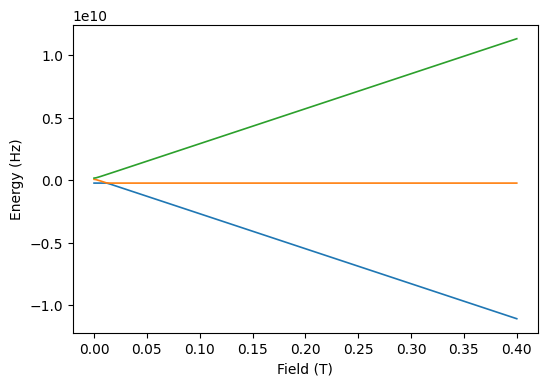

In [2]:
mars.visualization.plot_energy_system(sample_1, B_range=(0.0, 0.4))

In [3]:
%load_ext autoreload
%autoreload 2

init_populations = [0.5015, 0.5, 0.5015] # Let's make them almoust equel
init_populations  = [pop / sum(init_populations) for pop in init_populations]

out_probs = torch.tensor([1.0, 1.0, 1.0]) * 100 # 10 ms is some depopulation time

# Level 0 ↔ Level 1 and Level 1 ↔ Level 2 at 1000 s⁻¹ (~1 ms equilibration).
# Note that you do not need to specify the diagonal elements manually, they are set automatically during calculations.
free_probs = torch.tensor([[0.0, 1.0, 0.0],
                           [1.0, 0.0, 1.0],
                           [0.0, 1.0, 0.0]]) * 1000 # 1 ms is time of equilibration for triplet relaxation.


# We set context for the first subsystem
context_zfs_1 = mars.population.Context(sample=sample_1, basis="zfs", init_populations=init_populations, out_probs=out_probs)

# We set context for the second subsystem. Let it be the same again
context_zfs_2 = mars.population.Context(sample=sample_2, basis="zfs", init_populations=None, out_probs=out_probs)

# We set context for the first subsystem
context_zfs_3 = mars.population.Context(sample=sample_1, basis="zfs", init_populations=init_populations, out_probs=out_probs)

# We set context for the second subsystem. Let it be the same again
context_zfs_4 = mars.population.Context(sample=sample_2, basis="zfs", init_populations=None, out_probs=out_probs)


context_zfs_1 @ context_zfs_2 + context_zfs_3 @ context_zfs_4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SummedContext(
  (component_contexts): ModuleList(
    (0-1): 2 x KroneckerContext(
      (component_contexts): ModuleList(
        (0-1): 2 x Context()
      )
    )
  )
)

In [7]:
context_zfs_1 @ context_zfs_2 + context_zfs_3 @ context_zfs_4

SummedContext(
  (component_contexts): ModuleList(
    (0-1): 2 x KroneckerContext(
      (component_contexts): ModuleList(
        (0-1): 2 x Context()
      )
    )
  )
)

In [8]:
out = (context_zfs_1 + context_zfs_2) @  (context_zfs_3 + context_zfs_4)

In [10]:
out.component_contexts[1].basis.shape

torch.Size([210, 1, 9, 9])